#### Second attempt at the python version of the centralised part of the microarray methylation analysis workflow (Quality control upto normalisation)
Using python as a shell to string together the specialised r functions used in the Exeter workflow

Loading in the required modules/packages

In [1]:
pip install methylsuite

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: methylcheck in c:\users\silke\appdata\roaming\python\python37\site-packages (from methylsuite) (0.8.4)


You should consider upgrading via the 'c:\Program Files (x86)\Microsoft Visual Studio\Shared\Python37_64\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
import subprocess
import csv
import glob
import os
import re
import seaborn as sns
from matplotlib import pyplot as plt
import methylcheck

# stuff needed for some specific analysis - maybe not needed in this version of the code
#from sklearn.decomposition import PCA 
#from scipy.stats import pearsonr
#from sklearn.cluster import KMeans

In [2]:
working_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis"
data_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data"
output_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Federated_Differential_Methylation_Analysis\\Output"


Use subprocess to read the data contained in the idat files into dataframe using the readEPIC function from the wateRmelon package in R

### Creating an output file structure and loading in the idat files

The input arguments of this script are: 
1. file_path to the folder containing the .idat files 
2. file_path to the phenotype information sheet (.txt) 
3. the directory where the output should be saved 
4. OPTIONAL the data identifier to be used in the creation of the output folders - this still needs to be fixed

In [7]:
load_with_option = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Loading_idats_code_saveOutput_python_shell.R", "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\idat", "E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_RAW\GSE66351_pheno.txt", "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Federated_Differential_Methylation_Analysis\\Output", "GSE66351a"], capture_output=True)

In [ ]:
print(load_with_option.stderr)

Using subprocess to perform the central preprocessing workflow upto the normalisation  
This is the whole preprocessing run as one function in the r-script. The script takes 5 input arguments:  
1. The file path of the folder containing the .idat files
2. The phenotype information file
3. The working directory where the output folder should be created
4. The filepath to the illumina manifest file that contains the column "CHR" with the chromosome each probe is located on
5. The identifier that should be included in the name of the output folder


In [3]:
script_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Preprocessing_Rscripts\\centralised_preprocessing_half.r"
idat_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\idat"
pheno_path = "E:\Msc Systems Biology\MSB5000_Master_Thesis\Practical work\Data\GSE66351_RAW\GSE66351_pheno.txt"
output_dump = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\Practical work\\Federated_Differential_Methylation_Analysis\\Output"
manifest_path = "E:\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GSE66351\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
identifier = "GSE66351"

In [4]:
central_preprocessing = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', script_path, idat_path, pheno_path, output_dump, manifest_path, identifier], capture_output = True)

In [ ]:
#check what happend in the subprocess
print(central_preprocessing.stderr)

Next step is to normalise the data, this step will be offered centrally and distributed/federated to be flexible to the researchers needs  
Below a implementation of the normalisation algorithm behind the dasen function in the wateRmelon package is provided

Dasen normalisation is a form of quantile normalisation that is performed for the two probe types seperately. The normalised data (betas), per probe type, are calculated using the normalised methylated and unmethylated intensities of each probe type.  
    betas (per probe) = quantile normalised methylated intensities / (quantile normalised methylated intensities + quantile normalised unmethylated intensities + 100)  
The first step is to write the quantile normalisation function  
  
The python version of the dasen normalisation used in r can be found in the dasen_normalisation module

In [5]:
# Creating and loading the data to test the dasen normalisation translation

#create the probe-type annotation object
annotation_data = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv", skiprows=7, index_col=0, low_memory=False)
#annotation_data.set_index(annotation_data["IlmnID"], inplace=True)
probe_type_data = annotation_data.loc[:, "Infinium_Design_Type"]
#match it to the normalised data
meth_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_methylated_intensities.csv", index_col=0)
probe_type_data_test = probe_type_data.loc[list(set(probe_type_data.index.values).intersection(set(meth_test.index.values)))]
# load the unmethylated data
unmeth_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_unmethylated_intensities.csv", index_col =0)
beta_test = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\\Output\\QC_GSE66351\\Preprocessed_betas.csv", index_col =0)

In [6]:
meth = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\Filtered_Methylated.csv", index_col=0)
unmeth = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\Filtered_Unmethylated.csv", index_col=0)
beta = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\Filtered_Betas.csv", index_col=0)
probe_type_data = probe_type_data.loc[list(set(probe_type_data.index.values).intersection(set(meth.index.values)))]

In [9]:
probe_type_data.to_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Dasen_norm_test_data\\probe_annotation_full.csv")

INFO:methylcheck.samples.postprocessQC:Your data needed to be transposed (df = df.transpose()).
INFO:methylcheck.samples.postprocessQC:GSM2808875_8918692108_R01C02    78
GSM2808876_8918692108_R01C01    81
GSM2808877_8918692108_R02C02     7
GSM2808878_8918692108_R02C01    10
GSM2808879_8918692108_R03C02     4
                                ..
GSM2809060_5854945011_R06C01     3
GSM2809061_5854945011_R01C02     3
GSM2809062_5854945011_R03C02     1
GSM2809063_5854945011_R04C02     5
GSM2809064_5854945011_R05C02     0
Length: 190, dtype: int64


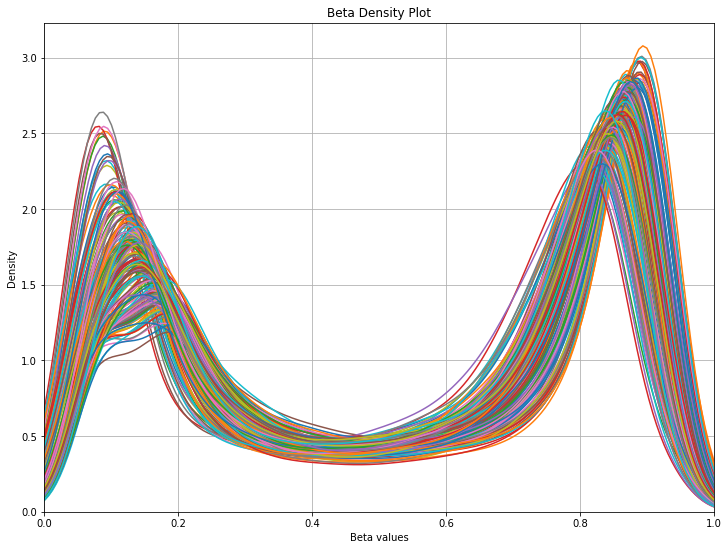

In [8]:
# plot the beta density distrubition before normalisation
methylcheck.beta_density_plot(beta, verbose=True)

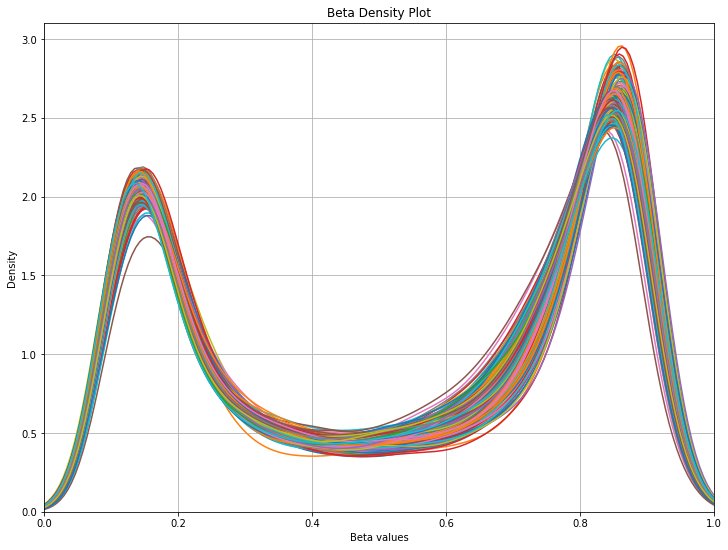

In [9]:
import dasen_normalisation
test_normalised_betas_module = dasen_normalisation.dasen_normalisation(unmeth, meth, probe_type_data)
test_normalised_betas_module.to_csv(os.path.join(output_path, "all_probes_samples_normalised_betas.csv"))


In [ ]:
# confirm the beta density plot looks smoother after normalisation
methylcheck.beta_density_plot(test_normalised_betas_module)

In [ ]:
# PCAs to check for batch effects on nomalised GSE66351 data
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns
n_comp = 10
PCA = PCA(n_components=n_comp)
PCA_out = PCA.fit(test_normalised_betas_module)
data_to_plot = pd.DataFrame({"PC1":PCA_out.components_[0], "PC2":PCA_out.components_[1], "Sentrix_ID":pheno.loc[:, "Sentrix_ID"]}, index=pheno.index.values)
sns.lmplot(x="PC1", y = "PC2", hue="Sentrix_ID", data = data_to_plot, fit_reg=False)

R script containing the RefFreeEWAS cell type decomposition which will be run in a subprocess, output saved and added to the phenotype information that will be used in the EWAS furhter down in this file

In [18]:
# specifying the paths that go into the subprocess function
file_path = os.path.join(working_path, "RefFreeEWAS_local.r") #this one requires .RData input
data_path = os.path.join(output_path, "QC_GSE66351", "preprocessed_MethyLumiSet.RData") #try again with different input data
manifest_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
pheno_path = os.path.join(output_path, "QC_GSE66351", "pre_norm_pheno_information.csv")
output_dir = os.path.join(output_path, "QC_GSE66351")


# RefFreeEWAS subprocess
RefFreeEWAS_RData = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', file_path, data_path, pheno_path, manifest_path, output_dir], capture_output=True)
RefFreeEWAS_RData.stdout

RefFreeEWAS for local input (.csv file with normalised betas)

In [34]:
# specifying the paths that go into the subprocess function
file_path = os.path.join(working_path, "RefFreeEWAS_local_csvinput.r") 
data_path = os.path.join(output_path, "QC_GSE66351", "Preprocessed_betas.csv") 
manifest_path = "E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\GSE66351_RAW\\GPL13534_HumanMethylation450_15017482_v.1.1.csv"
pheno_path = os.path.join(output_path, "QC_GSE66351", "pre_norm_pheno_information.csv")
output_dir = os.path.join(output_path, "QC_GSE66351")


# RefFreeEWAS subprocess
RefFreeEWAS = subprocess.run(["C:\\Program Files\\R\\R-4.1.2\\bin\\Rscript.exe", '--vanilla', file_path, data_path, pheno_path, manifest_path, output_dir], capture_output=True)
RefFreeEWAS.stdout

EWAS code, based on the least squares linear algebra as used in the fortran code at the foundation of the lm() function in r

In [14]:
#EWAS

import numpy as np
import pandas as pd

pheno = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\Data_Full_Datasets\\GSE66351\\Reduced_Pheno_Info.csv", index_col= "Sample_ID")
betas = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Federated_Differential_Methylation_Analysis\Output\\all_probes_samples_normalised_betas.csv", index_col=0)
x = pheno.loc[:,["Diagnosis", "Age", "Sex", "Sentrix_ID"]] # design matrix with the dependent/explainatory variables to be included in the model
y = betas.iloc[0:21,:] # keeping it small now to test if everything works the way it should

# The design matrix needs to consist of numeric representations of the covariates to be included in the model, i.e. binary diagnosis, binary sex, dummy sentrix etc.
x["Diagnosis"] = (x["Diagnosis"] == " AD").astype(int) #create binary diagnosis with 1 = AD and 0 = CTR
x["Sex"] = (x["Sex"] == " F").astype(int) #create binary sex with 1 = F and 0 = M
# create dummy variables for the unique sentrix_ids present in the dataset - this code can be reused to create center number dummies in the federated version of the code
unique_ids = x["Sentrix_ID"].unique()
for id in unique_ids:
    x[id] = (x["Sentrix_ID"] == id).astype(int)
x.drop(columns="Sentrix_ID", inplace = True)
# turn the age variable into a continuous numerical variable without any leftover text
x["Age"].replace("^[^:]*:", "", regex=True, inplace=True)
x["Age"] = pd.to_numeric(x["Age"])

def EWAS_central(design_matrix, beta_values):
    import numpy as np
    import pandas as pd
    import scipy.stats
    from statsmodels.stats.multitest import multipletests
    x_matrix = design_matrix.values
    y_matrix = beta_values.values


    n = y_matrix.shape[0] # select the number of rows of the beta matrix - #genes that the linear model will be calculated for
    m = x.shape[1] #select the number of columns from the design matrix

    

    coefficient = []
    standard_error = []
    t_stat = []
    p_value = []
    corrected_pvalue = []

    for i in range(0, n):
        y_m = y_matrix[i, :]
        x_t = x_matrix.T @ x_matrix
        x_t_y = x_matrix.T @ y_m
        x_t_inv = np.linalg.inv(x_t)
        coef = x_t_inv @ x_t_y
        coefficient.append(coef)
        stan_er = np.diag(x_t_inv)
        standard_error.append(stan_er)
        t = coef/stan_er
        t_stat.append(t)
        df = y_matrix.shape[1]-2 #degrees of freedom is defined as number of observations - 2 
        p = scipy.stats.t.sf(t, df)
        p_value.append(p)
    #turn the results saved in lists into a dataframe for each covariate with the probe ids as index
    for i in range(0,len(p_value)):
        corrected_pvalue.append(multipletests(p_value[i], method="fdr_bh")[1])
    results_corp = pd.DataFrame(corrected_pvalue, index=y.index, columns=x.columns)
    result_coef = pd.DataFrame(coefficient, index=y.index, columns=x.columns)
    result_staner = pd.DataFrame(standard_error, index = y.index, columns=x.columns)
    result_pvalue = pd.DataFrame(p_value, index=y.index, columns=x.columns)

    #create a final results dataframe that contains the coefficient, standard error and p-value of the diagnosis covariate included in the linear regression
    results_diagnosis = pd.DataFrame({"Diagnosis_Coef":result_coef["Diagnosis"], "Diagnosis_StanErr":result_staner["Diagnosis"],
        "Diagnosis_Pvalue":result_pvalue["Diagnosis"],
        "Diagnosis_CorP":results_corp["Diagnosis"]}, index=y.index)
    results_EWAS = pd.concat([result_coef, result_staner, result_pvalue, results_corp], axis = 1, keys = ["Coefficient", "Standard Error", "P-value", "Corrected P-value"])
    return results_diagnosis, results_EWAS

  


In [15]:
results_diagnosis, results_ewas = EWAS_central(x,y)

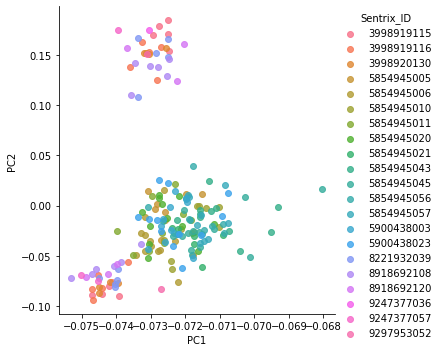

In [ ]:
#PCAs to check for batch effects on the EWAS residuals (?) after using sentrix ID in the regression model

In [ ]:
results_diagnosis.to_csv(os.path.join(output_path, "results_diagnosis_regression_python.csv"))
results_ewas.to_csv(os.path.join(output_path, "full_results_regression_python.csv"))

Create a .bed structured text file with the regression output to be used as input into the differentially methylated region analysis

In [63]:
# start with importing the probe information from the .bed file that is available through the encord project (?)
bed_annotation = pd.read_csv("E:\\Msc Systems Biology\\MSB5000_Master_Thesis\\Practical work\\Data\\HAIB.A549.EtOH.Rep.3.bed", sep="\t", header=None)
# select the three necessary column, chr, start, stop from the annotation file and match these to the probes in the EWAS input betas based on probe ID
bed_annotation = bed_annotation.iloc[:,0:4]
bed_annotation.columns = ["chr", "ChromStart", "ChromEnd", "Illumina_ID"]
# merge the regression output onto the .bed standard columns based on the probe ID
results_bed = pd.merge(bed_annotation, results_diagnosis, left_on="Illumina_ID", right_index=True, how="inner") #using inner join since this preserves the order of the keys and
# only keeps the entries that are present in both dataframes
results_bed.set_index(results_bed["Illumina_ID"], inplace=True)
# write the dataframe as a tab separated .bed file
results_bed.to_csv(os.path.join(output_path, "results_diagnosis_regression_test.bed"), sep="\t")